# Loading Data

In [53]:
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import cv2
from skimage.filters import threshold_otsu
from skimage.morphology import area_opening, remove_small_holes
from skimage.measure import label, regionprops


In [54]:
drive.mount('/content/drive')

In [55]:
!unzip /content/drive/MyDrive/archive.zip -d /content/data

In [56]:
# Define the path to your images folder
images_path = r'/content/data/combined_images'

# Create an ImageDataGenerator for loading images
image_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directory
dataset = tf.keras.utils.image_dataset_from_directory(
    images_path,
    seed=123,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

# Optional: Normalize pixel values
normalize_layer = tf.keras.layers.Rescaling(1./255)
dataset = dataset.map(lambda x, y: (normalize_layer(x), y))

# View sample images and labels
for images, labels in dataset.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")

Found 44000 files belonging to 4 classes.
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 4)


## Sample Images with Intesity Ranges

Class names: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


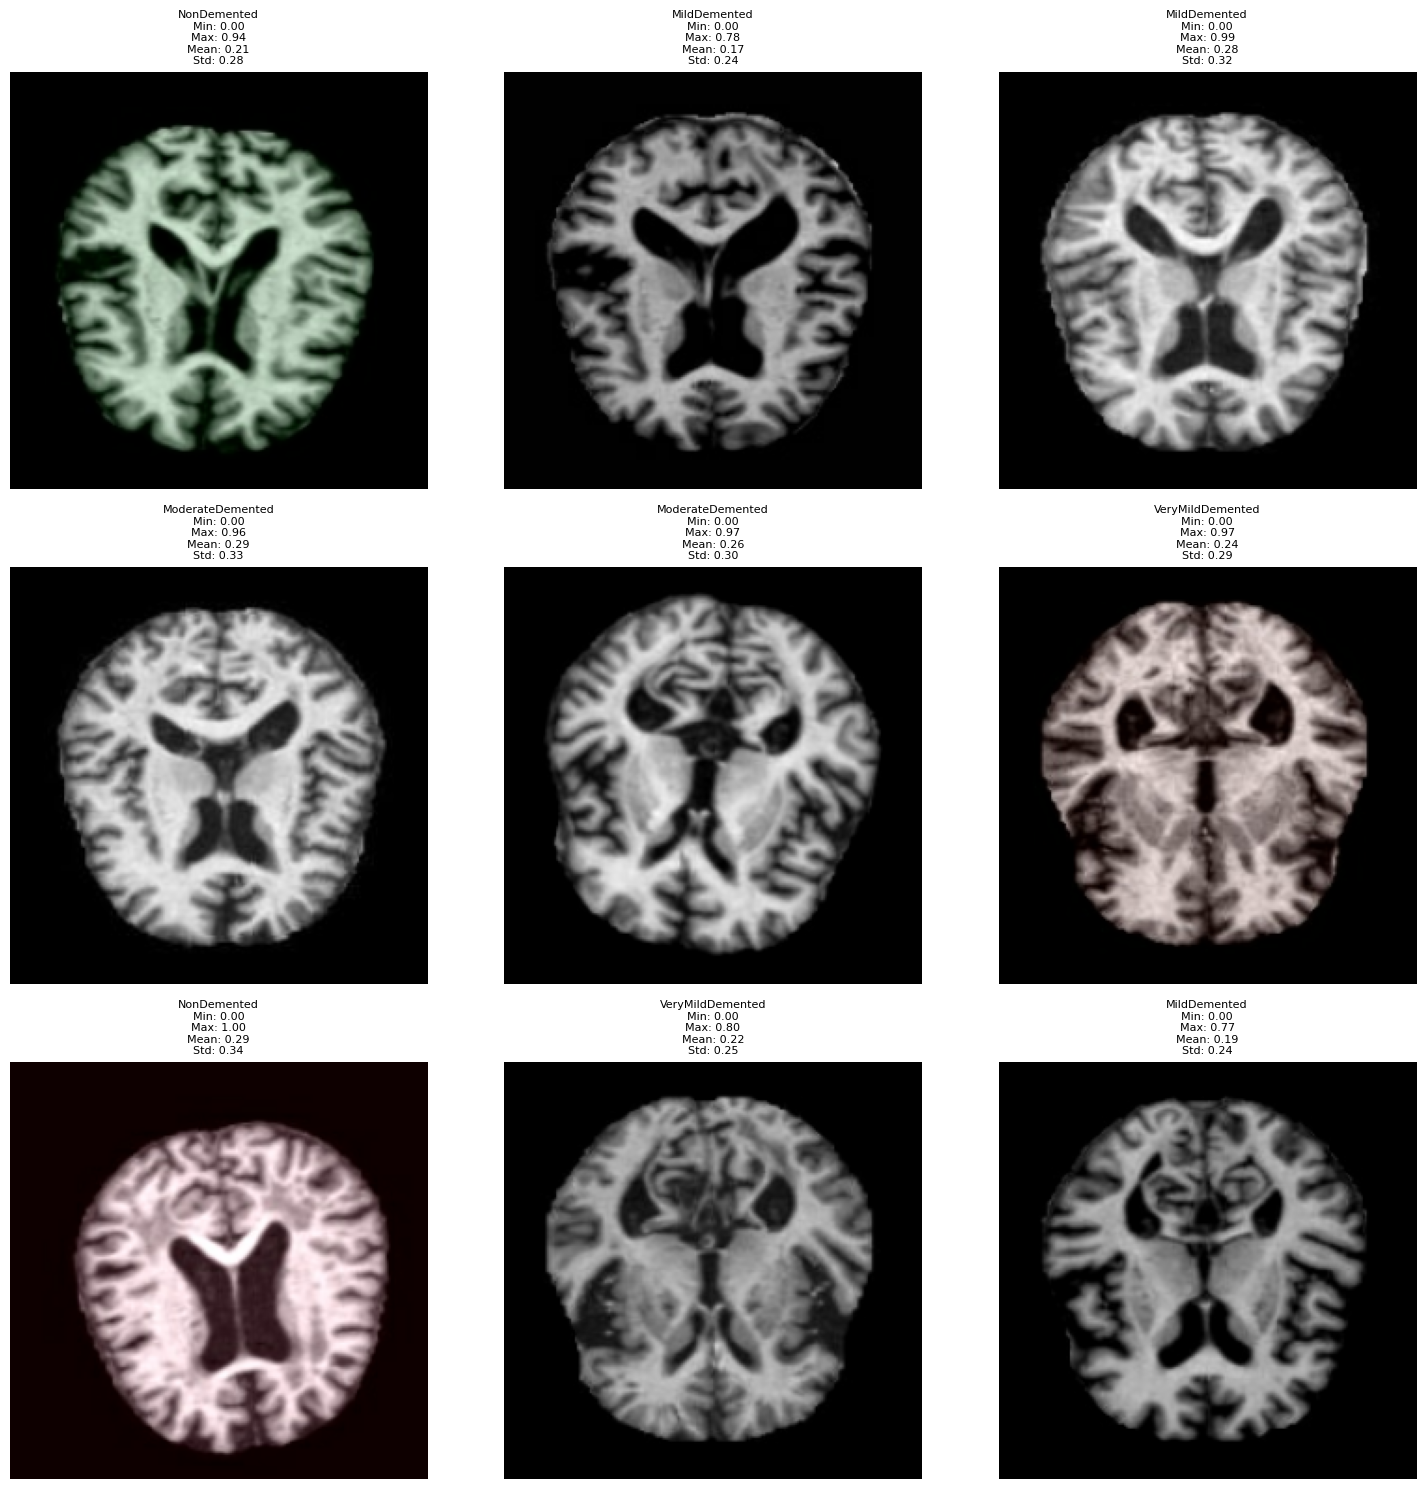

In [43]:
# Get class names from the directory
class_names = sorted(os.listdir(images_path))
print(f"Class names: {class_names}")

# Display first 9 images with labels and intensity stats
plt.figure(figsize=(15, 15)) # Increased figure size to accommodate more text
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img_array = images[i].numpy()
        plt.imshow(img_array)

        # Convert one-hot encoded label to class index
        class_index = np.argmax(labels[i])
        class_name = class_names[class_index]

        # Calculate intensity statistics
        min_intensity = np.min(img_array)
        max_intensity = np.max(img_array)
        mean_intensity = np.mean(img_array)
        std_intensity = np.std(img_array)

        stats_text = f"Min: {min_intensity:.2f}\nMax: {max_intensity:.2f}\nMean: {mean_intensity:.2f}\nStd: {std_intensity:.2f}"
        plt.title(f"{class_name}\n{stats_text}", fontsize=8) # Added stats to title
        plt.axis("off")

plt.tight_layout()
plt.savefig('sample_images_intensity_summary.png', dpi=150)
plt.show()

## Class Counts

Class Counts:
{'MildDemented': 10000, 'ModerateDemented': 10000, 'NonDemented': 12800, 'VeryMildDemented': 11200}



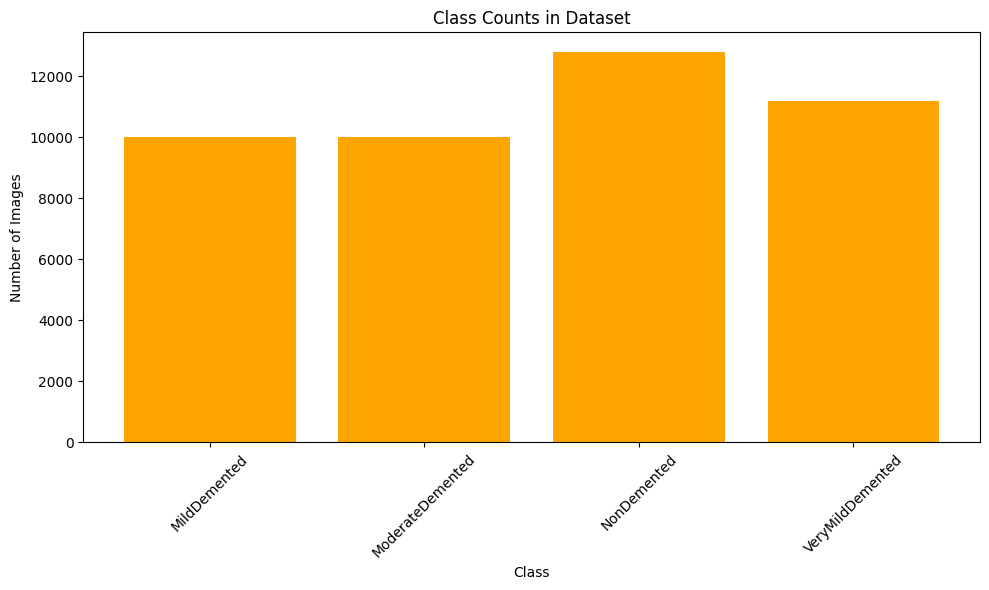

In [44]:
# Count images per class
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(images_path, class_name)
    count = len(os.listdir(class_path))
    class_counts[class_name] = count

print(f"Class Counts:\n{class_counts}\n")

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='orange')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Counts in Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('class_counts.png', dpi=150)
plt.show()

## Intensity Variability


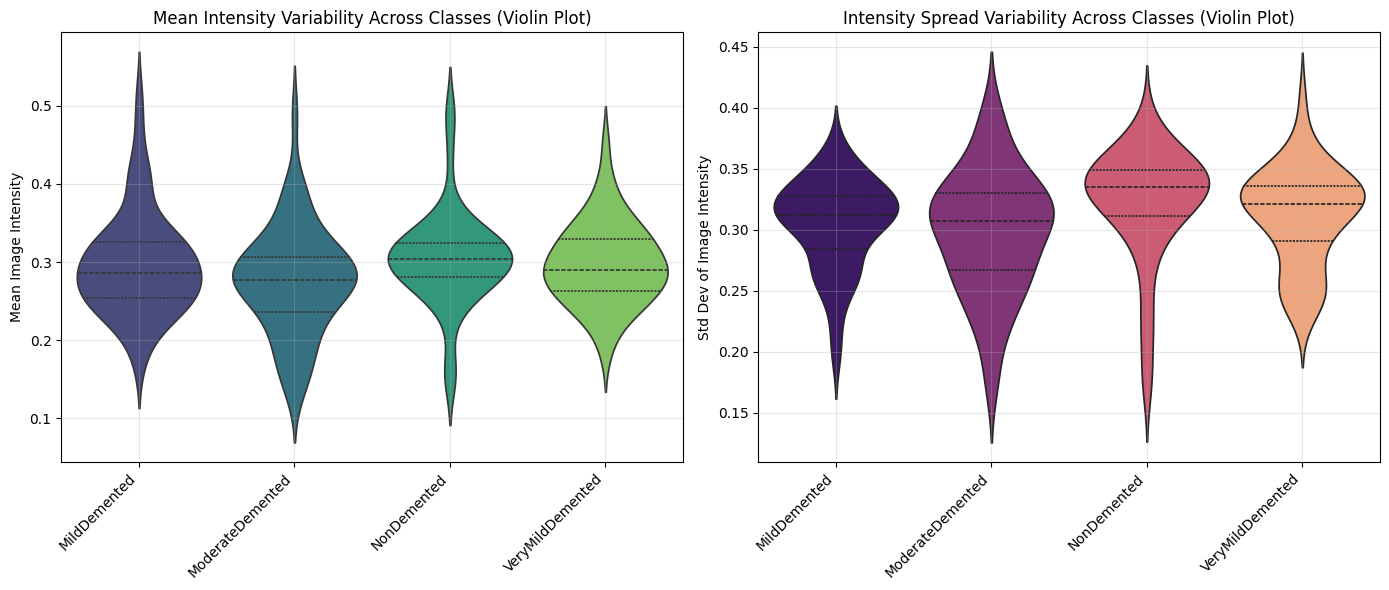

In [45]:
# This will show the variability clearly

# Initialize dictionary to store intensity statistics per class
intensity_stats = {class_name: {'means': [], 'stds': []} for class_name in class_names}

# Iterate through each class and collect intensity statistics
for class_name in class_names:
    class_path = os.path.join(images_path, class_name)
    image_files = os.listdir(class_path)

    # Sample a reasonable number of images for calculating stats
    for img_file in image_files[:50]: # Analyze up to 50 images per class for efficiency
        img_path = os.path.join(class_path, img_file)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0

        # Flatten the image array to calculate mean and std dev of all pixels
        mean_intensity = np.mean(img_array)
        std_intensity = np.std(img_array)

        intensity_stats[class_name]['means'].append(mean_intensity)
        intensity_stats[class_name]['stds'].append(std_intensity)

# Define classes using the already available class_names
classes = class_names

fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # Increased figure width for violin plots

# Violin plot of means
sns.violinplot(data=[intensity_stats[c]['means'] for c in classes],
               ax=axes[0], inner='quartile', palette='viridis')
axes[0].set_xticks(range(len(classes)))
axes[0].set_xticklabels(classes, rotation=45, ha='right')
axes[0].set_ylabel('Mean Image Intensity')
axes[0].set_title('Mean Intensity Variability Across Classes (Violin Plot)')
axes[0].grid(True, alpha=0.3)

# Violin plot of stds
sns.violinplot(data=[intensity_stats[c]['stds'] for c in classes],
               ax=axes[1], inner='quartile', palette='magma')
axes[1].set_xticks(range(len(classes)))
axes[1].set_xticklabels(classes, rotation=45, ha='right')
axes[1].set_ylabel('Std Dev of Image Intensity')
axes[1].set_title('Intensity Spread Variability Across Classes (Violin Plot)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('intensity_variability_violin.png', dpi=150)
plt.show()

## Positional Informaion

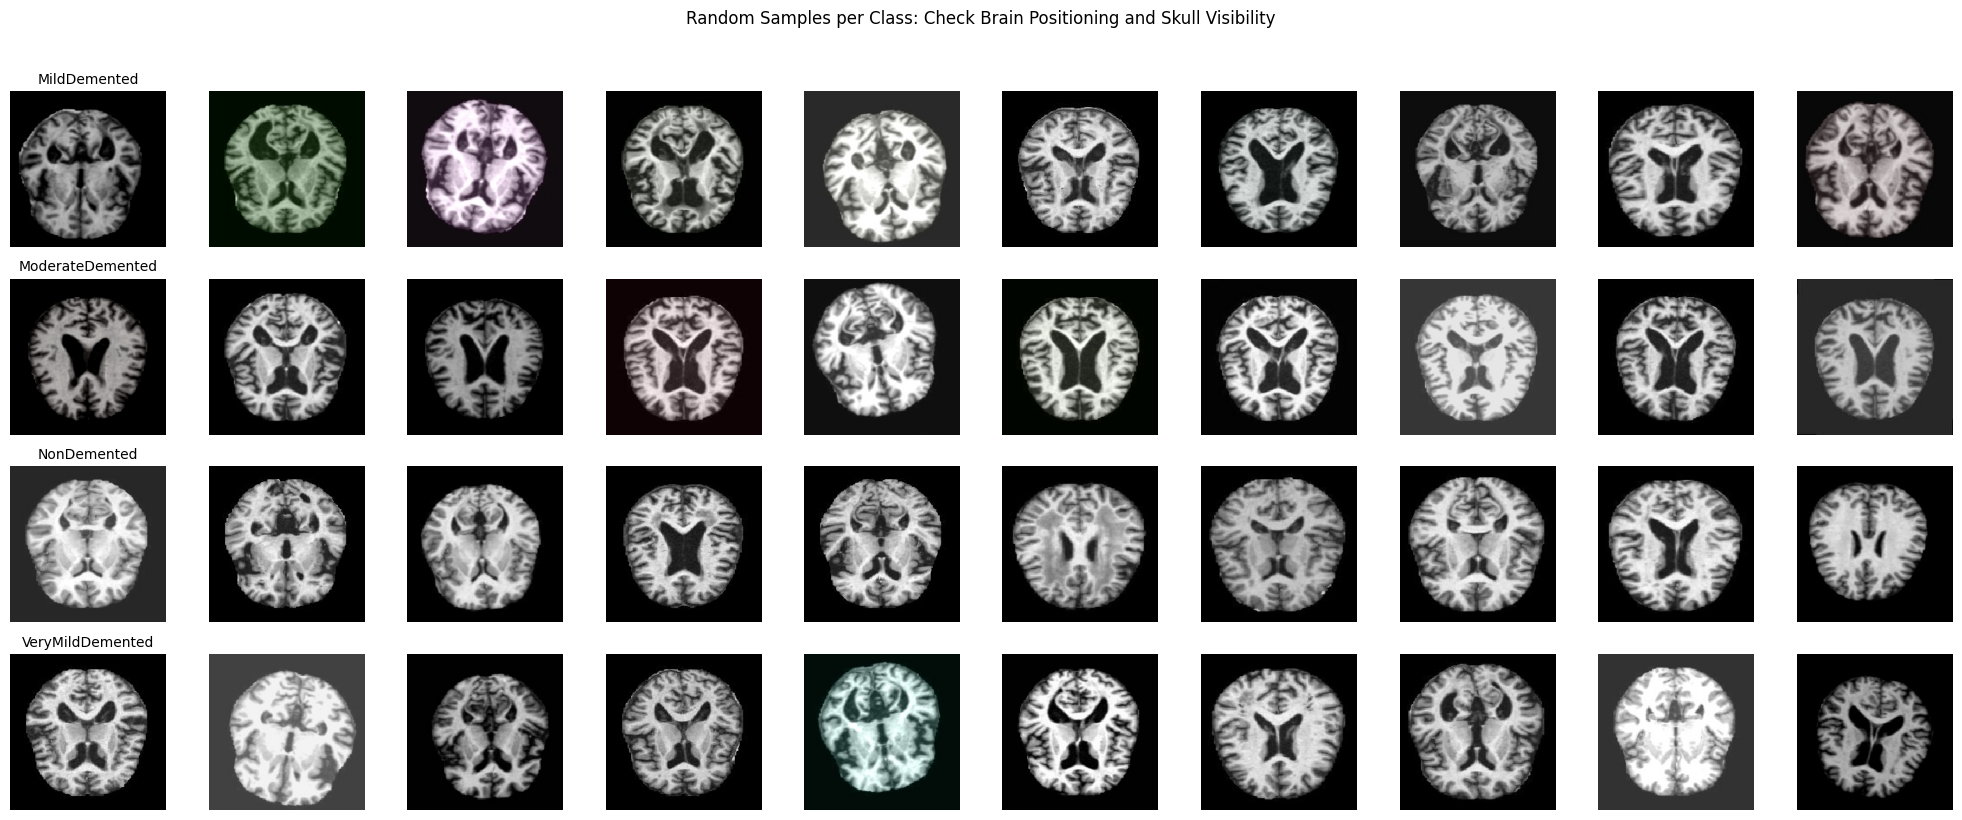

In [46]:
# Plot 10 random images from each class to visually inspect centering/skull
num_samples = 10
fig, axes = plt.subplots(len(class_names), num_samples, figsize=(num_samples*2, len(class_names)*2))

for row, class_name in enumerate(class_names):
    class_path = os.path.join(images_path, class_name)
    image_files = os.listdir(class_path)
    sample_files = random.sample(image_files, min(num_samples, len(image_files)))
    for col, img_file in enumerate(sample_files):
        img_path = os.path.join(class_path, img_file)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        if col == 0:
            axes[row, col].set_title(class_name, fontsize=10)

plt.suptitle("Random Samples per Class: Check Brain Positioning and Skull Visibility", y=1.02)
plt.tight_layout()
plt.savefig('positional_information.png', dpi=150)
plt.show()

## Noise Analysis

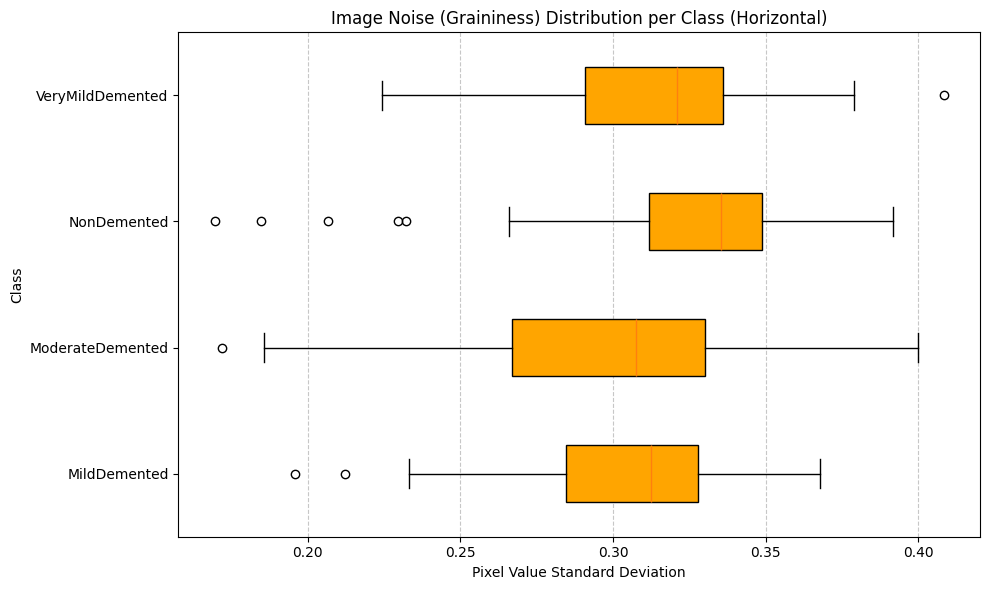

In [47]:
# Noise Analysis: Standard deviation of pixel values per image (per class)
noise_stats = {class_name: [] for class_name in class_names}

for class_name in class_names:
    class_path = os.path.join(images_path, class_name)
    image_files = os.listdir(class_path)
    for img_file in image_files[:50]:  # Analyze up to 50 images per class
        img_path = os.path.join(class_path, img_file)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        noise = np.std(img_array)
        noise_stats[class_name].append(noise)

# Plot boxplots of noise per class (horizontal and orange)
plt.figure(figsize=(10, 6))
plt.boxplot([noise_stats[c] for c in class_names], tick_labels=class_names, patch_artist=True, boxprops=dict(facecolor='orange'), vert=False)
plt.xlabel('Pixel Value Standard Deviation') # Swapped x and y labels for horizontal plot
plt.ylabel('Class') # Swapped x and y labels for horizontal plot
plt.title('Image Noise (Graininess) Distribution per Class (Horizontal)')
plt.yticks(rotation=0) # No rotation needed for vertical class labels
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('noise_analysis.png', dpi=150)
plt.show()

## Augmentation Potential

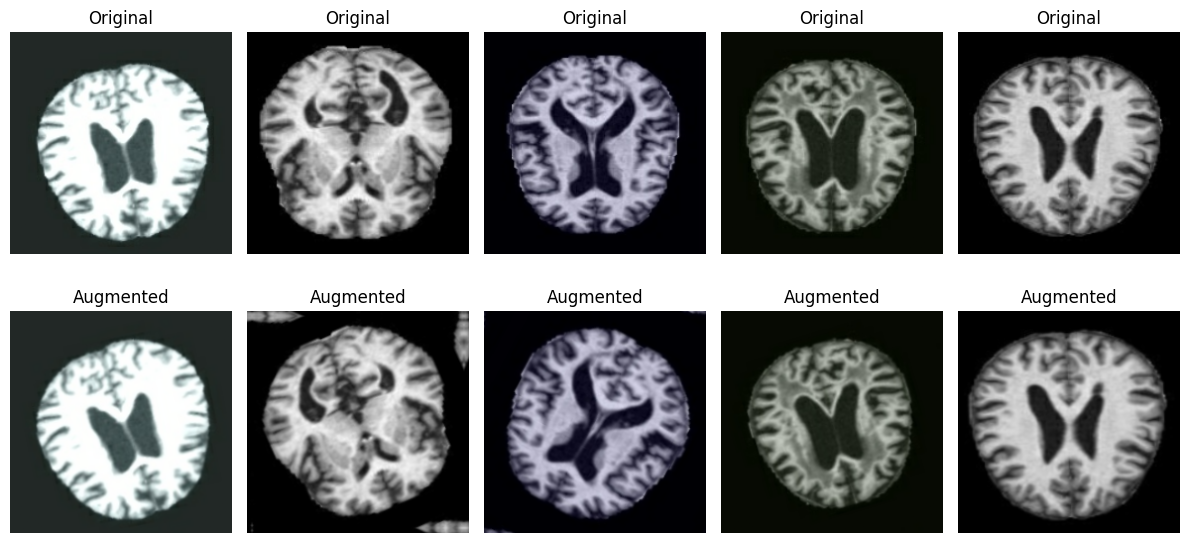

In [48]:
# Define augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Visualize augmentations on a few images from the dataset
plt.figure(figsize=(12, 6))
for images, labels in dataset.take(1):
    for i in range(5):
        augmented_img = data_augmentation(images[i:i+1], training=True)
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy())
        plt.title("Original")
        plt.axis("off")
        ax = plt.subplot(2, 5, i + 6)
        plt.imshow(augmented_img[0].numpy())
        plt.title("Augmented")
        plt.axis("off")
plt.tight_layout()
plt.savefig('augmentation_potential.png', dpi=150)
plt.show()

## Pixel Value Distribution

### 5 Number Summary

In [49]:
all_pixel_values_per_class = {class_name: [] for class_name in class_names}

for class_name in class_names:
    class_path = os.path.join(images_path, class_name)
    image_files = os.listdir(class_path)
    for img_file in image_files[:50]:  # Analyze up to 50 images per class for efficiency
        img_path = os.path.join(class_path, img_file)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        all_pixel_values_per_class[class_name].extend(img_array.flatten())


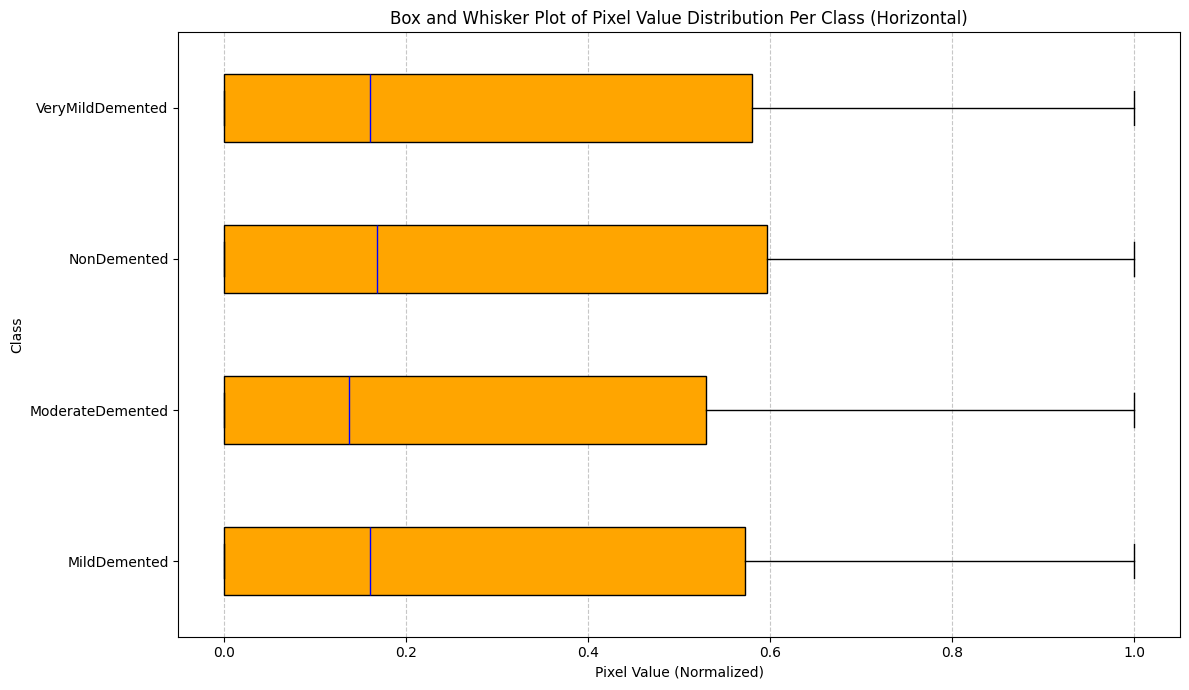

In [50]:
# Prepare data for box plot
plot_data = [all_pixel_values_per_class[class_name] for class_name in class_names]

plt.figure(figsize=(12, 7))
plt.boxplot(plot_data, tick_labels=class_names, patch_artist=True, medianprops=dict(color='blue'), boxprops=dict(facecolor='orange'), vert=False)
plt.ylabel('Class') # Y-axis will now represent classes
plt.xlabel('Pixel Value (Normalized)') # X-axis will now represent pixel values
plt.title('Box and Whisker Plot of Pixel Value Distribution Per Class (Horizontal)')
plt.yticks(rotation=0) # No rotation needed for vertical class labels
plt.grid(axis='x', linestyle='--', alpha=0.7) # Grid on x-axis for horizontal plot
plt.tight_layout()
plt.savefig('box_plot_pixel_distribution.png', dpi=150)
plt.show()

### Histogram

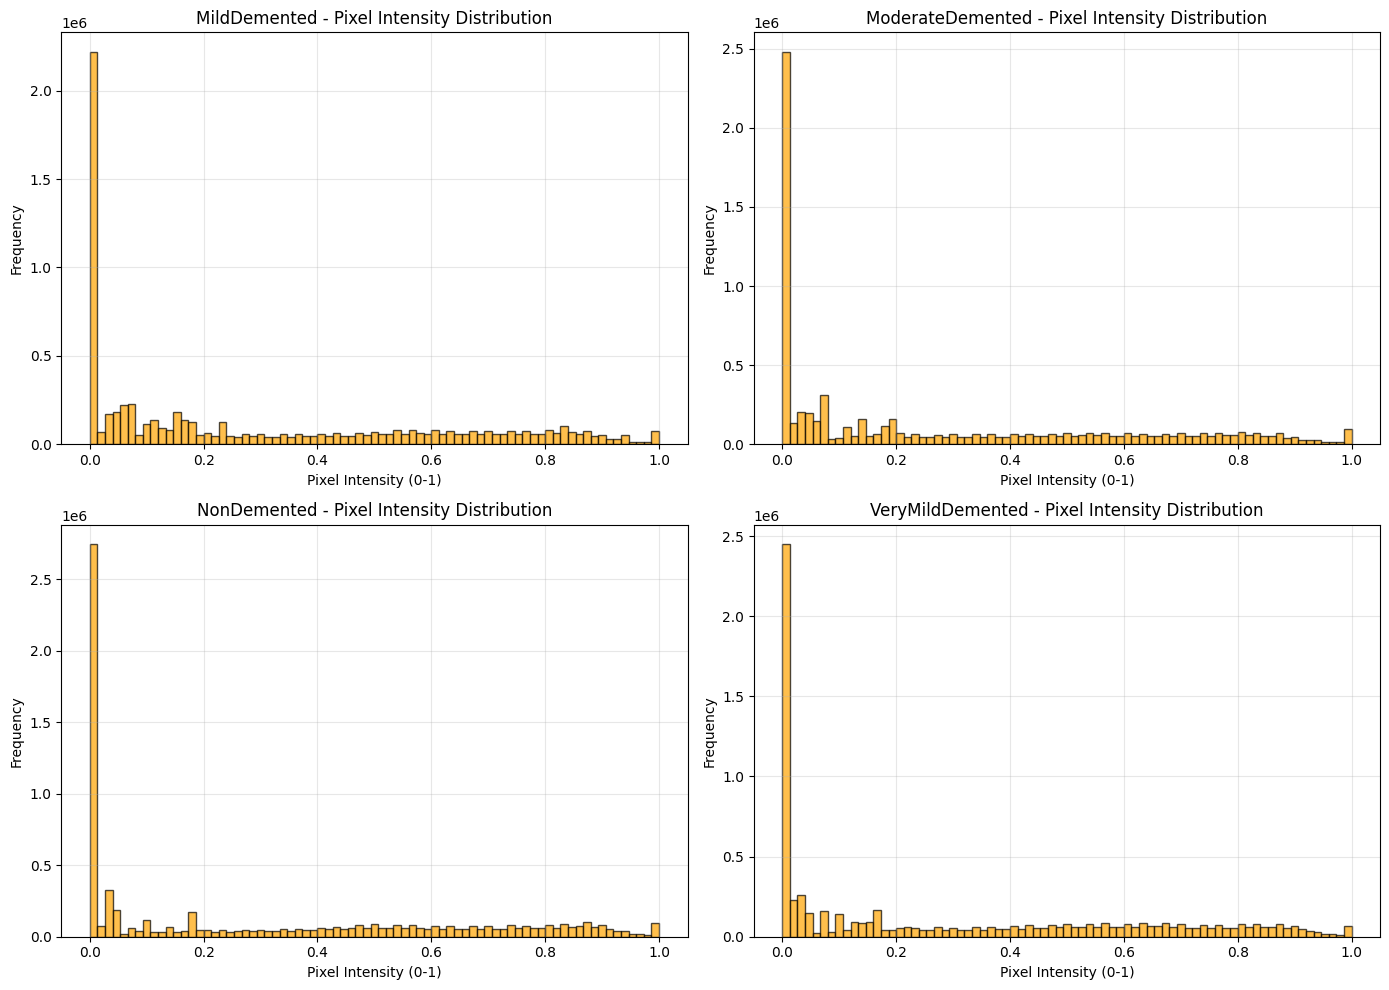

In [51]:
# Image Intensity Distributions by Class
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(images_path, class_name)
    image_files = os.listdir(class_path)

    # Collect pixel values from multiple images in this class
    all_pixels = []
    for img_file in image_files[:50]:  # Sample first 50 images per class
        img_path = os.path.join(class_path, img_file)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        all_pixels.extend(img_array.flatten())

    # Plot histogram
    axes[class_idx].hist(all_pixels, bins=75, color='orange', alpha=0.7, edgecolor='black')
    axes[class_idx].set_title(f'{class_name} - Pixel Intensity Distribution')
    axes[class_idx].set_xlabel('Pixel Intensity (0-1)')
    axes[class_idx].set_ylabel('Frequency')
    axes[class_idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('histogram_pixel_distribution.png', dpi=150)
plt.show()

### Log Scale

The black pixels are dominating the distribution making it difficult to understand the true distribution of the data. Log scaled will be used to achieve this

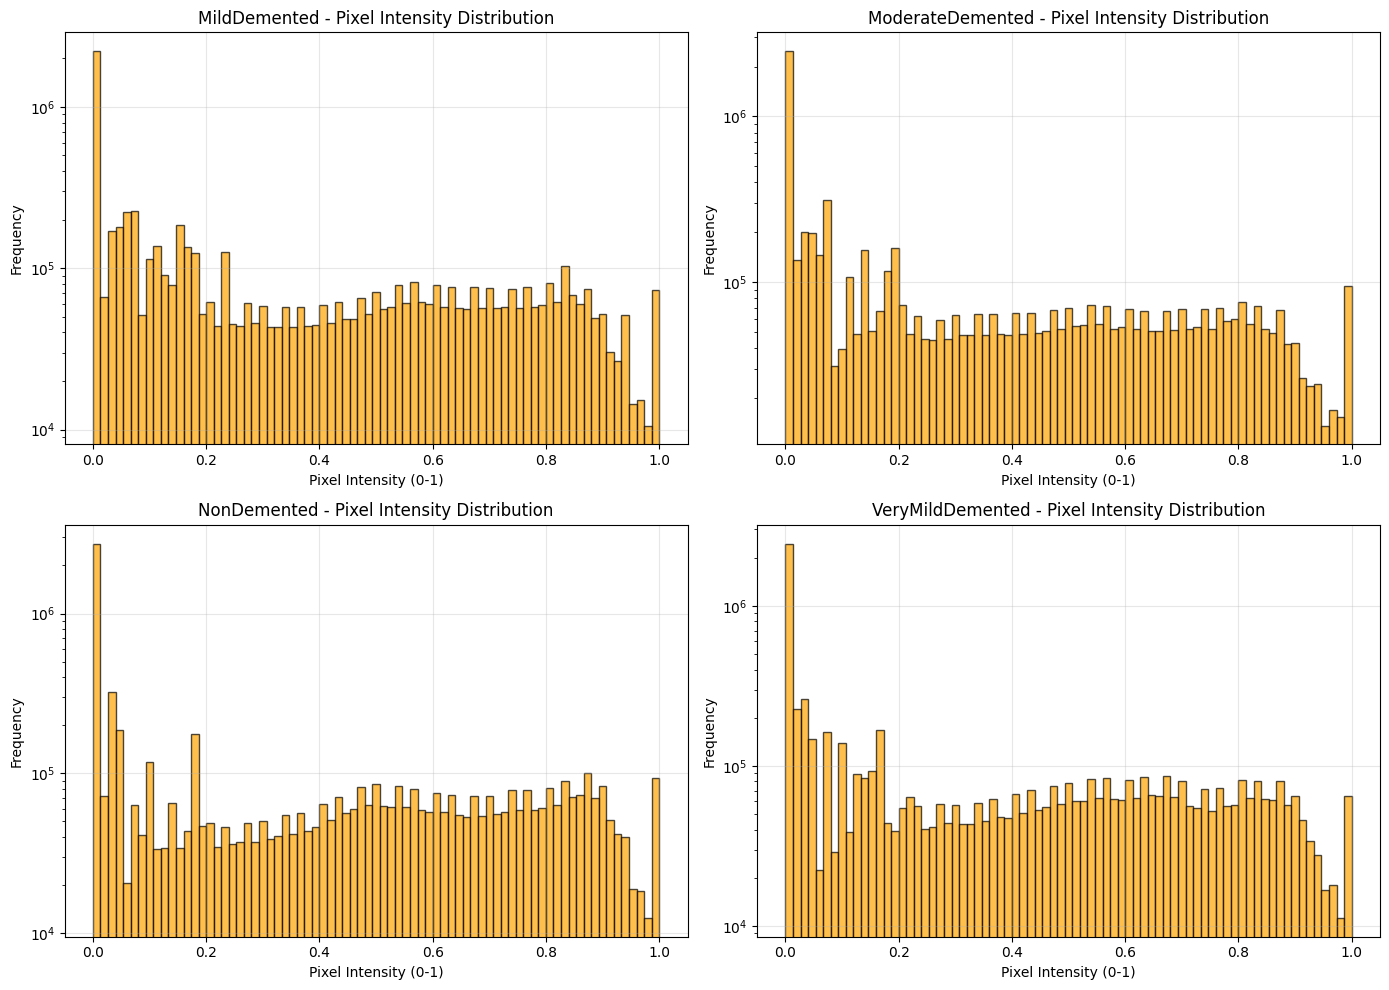

In [52]:
# Image Intensity Distributions by Class
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(images_path, class_name)
    image_files = os.listdir(class_path)

    # Collect pixel values from multiple images in this class
    all_pixels = []
    for img_file in image_files[:50]:  # Sample first 50 images per class
        img_path = os.path.join(class_path, img_file)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        all_pixels.extend(img_array.flatten())

    # Plot histogram
    axes[class_idx].hist(all_pixels, bins=75, color='orange', alpha=0.7, edgecolor='black')
    axes[class_idx].set_title(f'{class_name} - Pixel Intensity Distribution')
    axes[class_idx].set_xlabel('Pixel Intensity (0-1)')
    axes[class_idx].set_ylabel('Frequency')
    axes[class_idx].set_yscale('log')
    axes[class_idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('histogram_log_pixel_distribution.png', dpi=150)
plt.show()

# EDA Summary

# Exploratory Data Analysis Summary

## Dataset Overview
- **Total Images**: 44,000 images
- **Classes**: 4 (MildDemented, ModerateDemented, NonDemented, VeryMildDemented)
- **Class Distribution**:
  - MildDemented: 10,000 images (22.73%)
  - ModerateDemented: 10,000 images (22.73%)
  - NonDemented: 12,800 images (29.09%)
  - VeryMildDemented: 11,200 images (25.45%)
- **Image Dimensions**: 176 x 208 pixels (axial brain slices)
- **Color Space**: Grayscale MRI scans (converted to RGB for model input)
- **Data Source**: Pre-processed MRI scans with skull-stripping already performed

## Key Findings

### 1. Class Distribution and Balance

The dataset shows relatively **balanced class distribution** across all four dementia severity levels:
- NonDemented: 12,800 images (29.09%) - slightly higher representation
- VeryMildDemented: 11,200 images (25.45%)
- MildDemented: 10,000 images (22.73%)
- ModerateDemented: 10,000 images (22.73%)

**Implication**: The mild class imbalance (29% vs 23%) is not severe enough to require special handling like oversampling or class weights. The ratio between largest and smallest class is only 1.28:1, which is considered well-balanced. However, stratified sampling will be used during train/validation/test split to maintain proportional representation.

### 2. Pixel Intensity Distributions

Analysis of pixel intensity distributions revealed distinct patterns across dementia severity levels:

#### **NonDemented**:
- **Distribution shape**: Multi-modal with clear, distinct peaks
- **Primary characteristics**:
  - Large concentration of low-intensity pixels (background at 0.0)
  - Multiple well-defined peaks in the 0.05-0.1 range representing different tissue types
  - Clear secondary peak around 0.20 (gray-white matter differentiation)
- **Interpretation**: Healthy brain tissue shows well-preserved structural organization with distinct tissue types clearly separable by intensity

#### **VeryMildDemented**:
- **Distribution shape**: Multi-modal with more spread than NonDemented
- **Primary characteristics**:
  - Similar multi-peak structure to NonDemented but with broader peaks
  - Secondary peaks around 0.15-0.25 range
  - Wider distribution indicating early tissue changes
- **Interpretation**: Early-stage dementia shows beginning loss of sharp tissue boundaries while maintaining overall tissue differentiation

#### **MildDemented**:
- **Distribution shape**: Multi-modal with significant spreading
- **Primary characteristics**:
  - Multiple peaks across 0.05-0.30 range but less distinct
  - More uniform distribution across intensity values
  - Peaks are broader and less pronounced than NonDemented
- **Interpretation**: Progressive tissue changes with reduced contrast between tissue types; gray-white matter boundaries becoming less distinct

#### **ModerateDemented**:
- **Distribution shape**: Flatter, more uniform distribution with less distinct peaks
- **Primary characteristics**:
  - Main peak still at background (0.0)
  - Secondary peak around 0.10-0.15 (lower than other classes)
  - Broader, flatter distribution extending across 0.05-0.30 range
  - Multiple small peaks indicating heterogeneous tissue
- **Interpretation**: Significant loss of tissue contrast due to:
  - Advanced brain atrophy (tissue loss and ventricular enlargement)
  - White matter hyperintensities from vascular damage
  - Widespread loss of gray-white matter differentiation
  - Increased tissue heterogeneity

**Clinical Significance**: The progression from distinct multi-modal peaks (healthy) to flatter, more uniform distributions (severe dementia) directly aligns with known pathological changes in dementia progression. As the disease advances, brain tissue loses structural integrity, resulting in:
- Decreased tissue contrast (flatter histograms)
- Loss of clear tissue boundaries (broader peaks)
- Increased heterogeneity (more uniform distribution)

### 3. Intensity Scale Variability

MRI scans exhibit intensity scale variability due to different scanning protocols, scanner manufacturers, and acquisition parameters.

#### **Mean Intensity Variability**:
- All classes show **similar mean intensity distributions** centered around 0.25-0.30
- Substantial overlap across all dementia severity levels
- Range: 0.10-0.55 across individual images
- **Key finding**: Mean intensity alone is NOT discriminative between classes

#### **Intensity Spread (Standard Deviation) Variability**:
Based on the violin plots and noise analysis:

- **MildDemented**: Std dev concentrated around 0.30-0.33 (relatively tight)
- **ModerateDemented**: Std dev peaks around 0.28-0.32 with wide distribution
- **NonDemented**: Std dev concentrated around 0.30-0.34 (slightly higher, tighter distribution)
- **VeryMildDemented**: Std dev peaks around 0.30-0.33 (similar to NonDemented)

**Noise/Graininess Analysis**:
The graininess (pixel value standard deviation) shows:
- **NonDemented**: Median ~0.33, with several low-graininess outliers (0.18-0.23)
- **ModerateDemented**: Wider spread (0.20-0.40) with median ~0.30
- **MildDemented**: Similar spread to ModerateDemented
- **VeryMildDemented**: Median ~0.31, concentrated distribution

**Clinical Interpretation**:
- **Tissue heterogeneity** varies across disease stages
- ModerateDemented shows **wider variability** in tissue characteristics (some images very heterogeneous, others more uniform)
- NonDemented shows **consistent tissue structure** with occasional smoother scans
- The presence of outliers indicates scanning variability even within the same disease class

#### **Intensity Range Variability**:
From the sample images visualization:
- All images span similar normalized ranges (Min: 0.00, Max: 0.77-1.00)
- **Mean intensity varies significantly within same class**:
  - Example (NonDemented): Mean ranges from 0.21 to 0.29 across different scans
  - Example (ModerateDemented): Mean ranges from 0.26 to 0.29
- **Standard deviation varies within same class**:
  - NonDemented: Std ranges from 0.28 to 0.34
  - VeryMildDemented: Std ranges from 0.24 to 0.29

**Implication**: Even within the same disease class, different scans exhibit different mean intensities and tissue variability. This is due to:
- Scanner and protocol differences
- Natural biological variability
- Image acquisition parameters

**Preprocessing Requirement**: Per-image normalization is essential to ensure the model learns tissue contrast patterns (relative differences between tissue types) rather than absolute brightness levels that vary arbitrarily across scans.

### 4. Image Quality and Positional Information

#### **Spatial Alignment**:
The positional information visualization shows:
- All brain scans are **well-centered** in the image frame
- Consistent brain positioning across all classes
- Axial slice orientation is uniform
- Brain size and position show minimal variability

**Implication**: Minimal spatial preprocessing needed; images are already aligned

#### **Color Variations**:
Sample images show various color tints (green, pink, purple, standard grayscale):
- These are **visualization artifacts** from the dataset preprocessing
- Not actual differences in MRI acquisition
- Will be converted to standard grayscale during preprocessing
- No impact on model training as we normalize to single-channel intensity

#### **Image Quality**:
- All images show clear brain anatomy
- Skull-stripping already performed (clean brain boundaries)
- No visible major artifacts or motion blur
- Consistent image quality across all classes

### 5. Augmentation Potential

The augmentation visualization demonstrates appropriate transformations for medical imaging:
- **Rotation** (±10-15°): Preserves anatomical structure
- **Horizontal flip**: Maintains brain symmetry (anatomically valid)
- **Slight zoom/scaling**: Accounts for natural size variation

**Observations from augmentation examples**:
- Augmented images maintain diagnostic quality
- No loss of critical anatomical features
- Transformations appear natural and realistic

**Recommended augmentations**:
- Random rotation: ±15°
- Random horizontal flip: 50% probability
- Random zoom: 0.95-1.05 scale

## Implications for Model Development

### 1. Preprocessing Strategy
**Decision**: Implement **per-image robust normalization** (median/IQR-based)

**Rationale**:
- **Handles multiple distribution types**: Works effectively with Gaussian-like (NonDemented), multi-modal (VeryMild/Mild), and flat (Moderate) distributions
- **Accounts for arbitrary intensity scales**: Normalizes each scan relative to itself, removing scanner-specific brightness variations
- **Robust to outliers**: Uses median and IQR instead of mean and standard deviation, making it less sensitive to bright/dark outliers
- **Preserves tissue relationships**: Ensures model learns tissue contrast patterns (e.g., white matter is brighter than gray matter) rather than absolute intensity values

### 2. Class Imbalance Handling
**Strategy**: Stratified sampling only (no special balancing needed)

**Rationale**:
- Imbalance is mild (29% vs 23% - 1.28:1 ratio)
- All classes have substantial representation (≥10,000 images each)
- Stratified train/val/test split maintains proportional representation
- No need for oversampling, undersampling, or class weights

### 3. Model Selection Justification
**Chosen architectures**: ResNet50, EfficientNet-B0, DenseNet121

**Rationale**:
- **Transfer learning benefits**: Pre-trained ImageNet weights provide strong general feature extraction
- **Proven medical imaging performance**: All three architectures have been successfully applied to medical image classification
- **Architectural diversity**:
  - ResNet50: Residual connections for deep feature learning
  - EfficientNet-B0: Balanced efficiency and accuracy with compound scaling
  - DenseNet121: Dense connections for maximum feature reuse
- **Computational feasibility**: All three can be trained in reasonable time (~1-2 hours each)
- **Comparison value**: Testing multiple architectures identifies which approach best captures dementia-related features

### 4. Training Configuration

**Data Split**:
- Train: 70% (~30,800 images)
- Validation: 15% (~6,600 images)
- Test: 15% (~6,600 images)
- **Stratified by class** to maintain proportional representation

**Training Parameters** (initial recommendations):
- Batch size: 32 (adjust based on GPU memory)
- Learning rate: 0.001 (Adam optimizer)
- Epochs: 15-20 with early stopping (patience=5)
- Learning rate scheduler: ReduceLROnPlateau (patience=3, factor=0.5)
- Loss function: CrossEntropyLoss

**Expected Training Time**:
- ResNet50: 1.5-2 hours
- EfficientNet-B0: 1-1.5 hours
- DenseNet121: 1.5-2 hours
- **Total**: 4-6 hours (sequential training, single GPU)

## Conclusion

The EDA revealed several critical insights about dementia progression in MRI scans:

1. **Disease progression is visible in intensity distributions**: Healthy brains show distinct multi-modal patterns (clear tissue separation), while advanced dementia shows flatter distributions (tissue degradation and loss of contrast).

2. **Intensity scales are arbitrary and variable**: The same disease stage appears at different brightness levels across scans, necessitating per-image normalization to ensure model generalization.

3. **Classes are distinguishable but subtly different**: While ModerateDemented shows clear distributional differences from NonDemented, adjacent classes (VeryMild vs Mild) may have overlapping features requiring sophisticated pattern recognition.

4. **Dataset quality is excellent**: Well-centered, skull-stripped images with consistent orientation and minimal artifacts provide a strong foundation for model training.

5. **Multi-modal approach is justified**: Testing three different CNN architectures allows identification of which feature extraction strategy best captures the subtle, multi-scale patterns of dementia-related brain changes.

These findings inform our preprocessing pipeline (per-image robust normalization), augmentation strategy (conservative transformations appropriate for medical imaging), and model training approach (transfer learning with diverse architectures). The analysis positions us to develop robust classification models that learn meaningful anatomical patterns rather than scanner-specific artifacts, with the potential to generalize well to new data.

## Next Steps

1. **Implement preprocessing pipeline**: Per-image robust normalization with color normalization
2. **Create stratified train/val/test split**: 70/15/15 split maintaining class proportions
3. **Set up data augmentation**: Rotation, horizontal flip, zoom within medical imaging constraints
4. **Train three CNN architectures**: ResNet50, EfficientNet-B0, DenseNet121 with early stopping
5. **Evaluate and compare models**: Test set performance, confusion matrices, per-class metrics
6. **Select best model**: Based on overall accuracy, class-specific performance, and computational efficiency
7. **Document findings**: Comprehensive report explaining model selection, performance, and clinical implications